使用設備: cuda
Data and annotations loaded successfully!
Number of training images: 1502
Number of validation images: 429
Number of test images: 215

Sample of training annotation keys:
dict_keys(['info', 'licenses', 'categories', 'images', 'annotations'])

Example of a training annotation:
info: {'year': '2023', 'version': '1', 'description': 'Exported from roboflow.com', 'contributor': '', 'url': 'https://public.roboflow.com/object-detection/undefined', 'date_created': '2023-08-19T04:37:54+00:00'}
Number of annotations: 1502

Sample annotations (first 3 entries):
Annotation 1: {'id': 0, 'image_id': 0, 'category_id': 1, 'bbox': [145, 239, 168.75, 162.5], 'area': 27421.875, 'segmentation': [[313.75, 238.75, 145, 238.75, 145, 401.25, 313.75, 401.25, 313.75, 238.75]], 'iscrowd': 0}
Annotation 2: {'id': 1, 'image_id': 1, 'category_id': 1, 'bbox': [194, 176, 148.75, 233.75], 'area': 34770.313, 'segmentation': [[342.5, 176.25, 193.75, 176.25, 193.75, 410, 342.5, 410, 342.5, 176.25]], 'iscrowd':

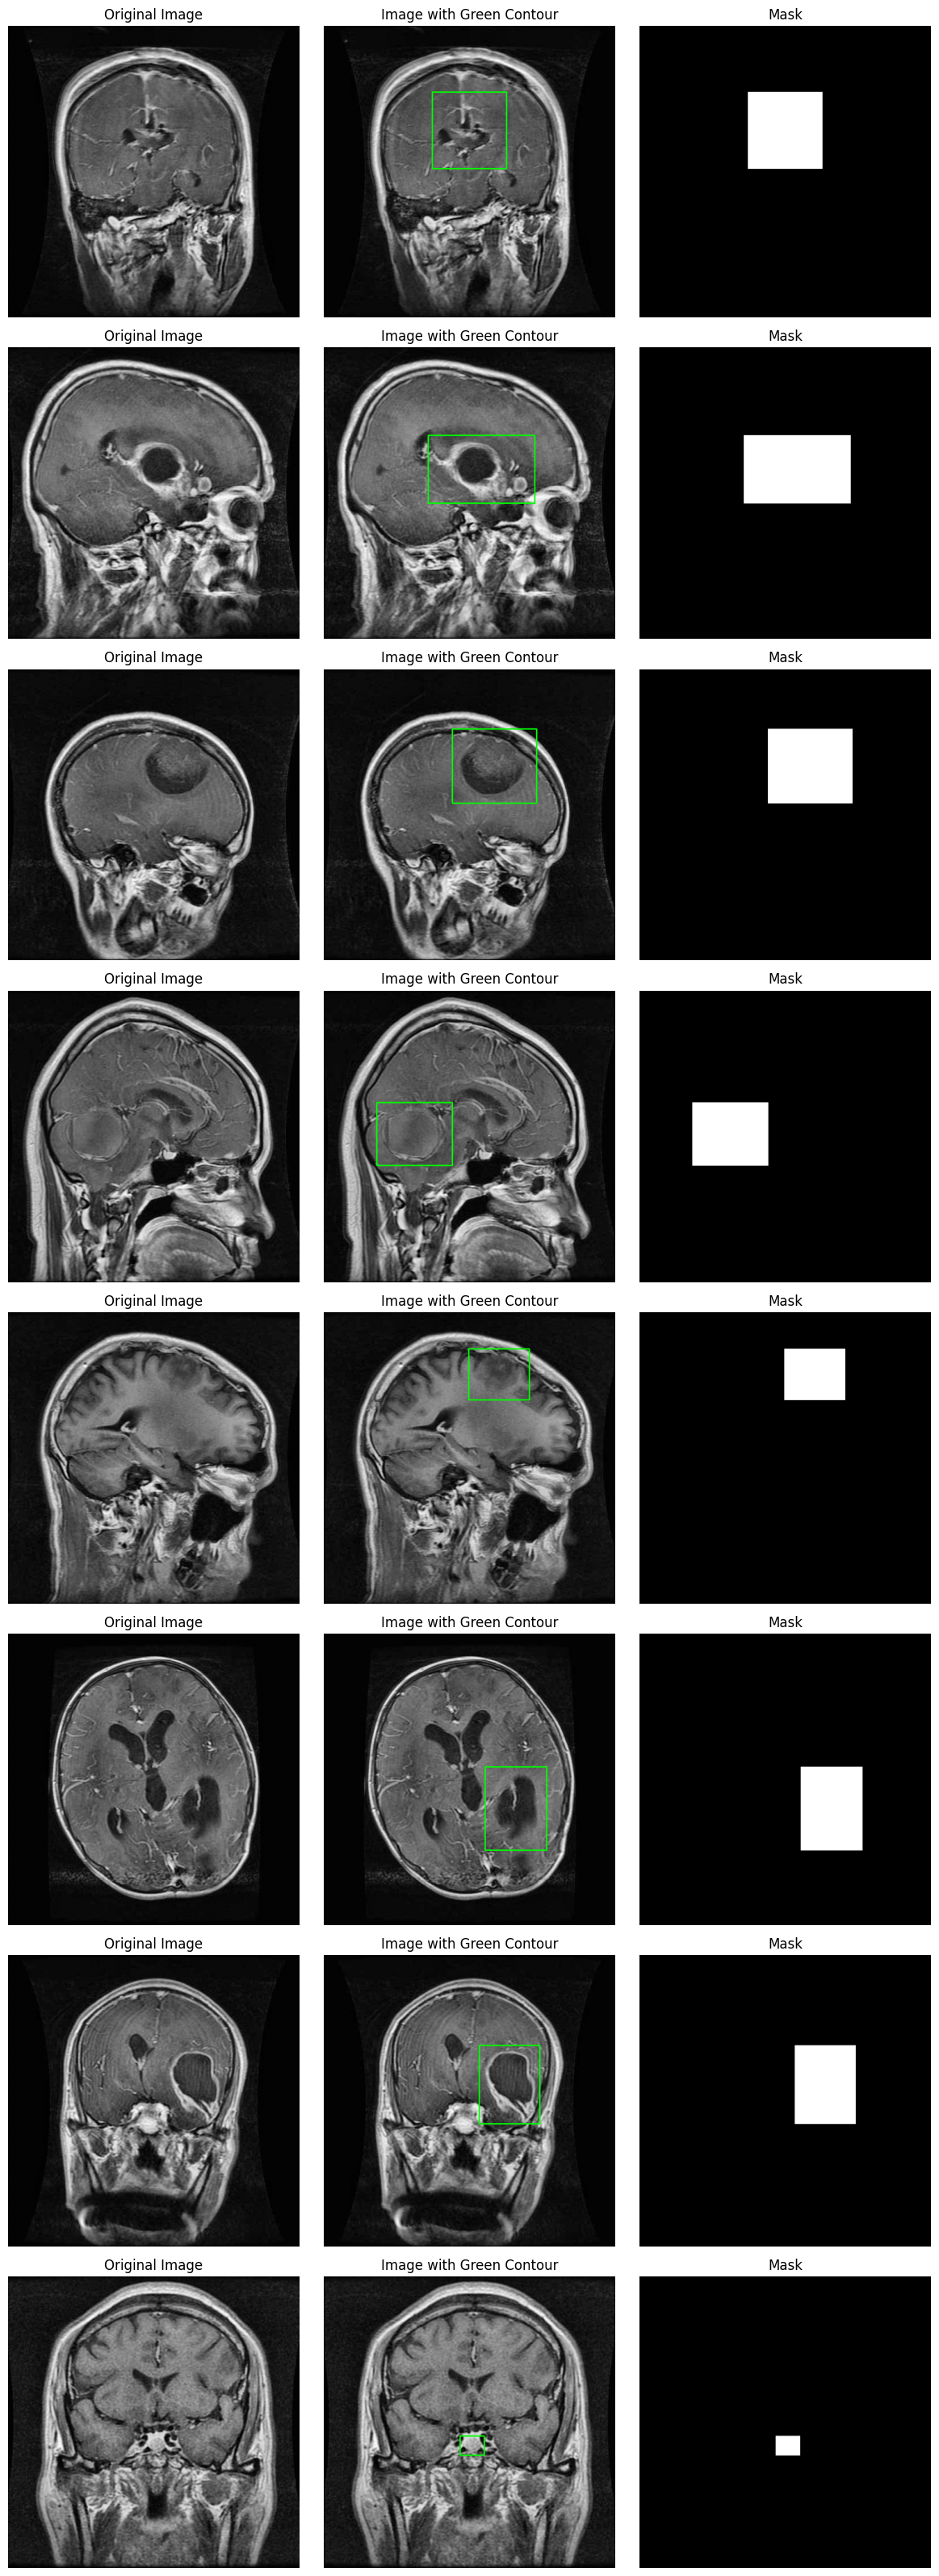

Data loaders with normalization method created successfully!
Images shape: torch.Size([4, 1, 640, 640])
Masks shape: torch.Size([4, 1, 640, 640])
First image (as tensor): tensor([[[0.0118, 0.0118, 0.0118,  ..., 0.0118, 0.0118, 0.0118],
         [0.0118, 0.0118, 0.0118,  ..., 0.0118, 0.0118, 0.0118],
         [0.0118, 0.0118, 0.0118,  ..., 0.0118, 0.0118, 0.0118],
         ...,
         [0.0118, 0.0118, 0.0118,  ..., 0.0118, 0.0118, 0.0118],
         [0.0118, 0.0118, 0.0118,  ..., 0.0118, 0.0118, 0.0118],
         [0.0118, 0.0118, 0.0118,  ..., 0.0118, 0.0118, 0.0118]]])
First mask (as tensor): tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]])
U-Net model created successfully!
UNet(
  (enc1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): 

NameError: name 'cp' is not defined

In [10]:
# -*- coding: utf-8 -*-
import os
import glob
import json
import numpy as np
import cv2

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

# 測試 GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用設備: {device}")

# 定義一個簡單的數據集
# Set the directory paths for training, testing, and validation datasets
train_path = 'dataset/train/'
test_path = 'dataset/test/'
valid_path = 'dataset/valid/'

# If running the code on Kaggle, use the following paths for datasets
# train_path = '/kaggle/input/brain-tumor-image-dataset-semantic-segmentation/train/'
# test_path = '/kaggle/input/brain-tumor-image-dataset-semantic-segmentation/test/'
# valid_path = '/kaggle/input/brain-tumor-image-dataset-semantic-segmentation/valid/'

# Load image file names from the directories and filter to include only '.jpg' files
train_data = [image for image in os.listdir(train_path) if image.endswith('.jpg')]
test_data = [image for image in os.listdir(test_path) if image.endswith('.jpg')]
valid_data = [image for image in os.listdir(valid_path) if image.endswith('.jpg')]

# 創建數據集與數據加載器
# Load annotation files (in JSON format)
def load_annotation_files(path):
    # Get a list of all JSON files in the specified directory
    json_files = glob.glob(os.path.join(path, "*.json"))

    # If no JSON files are found, raise an error
    if len(json_files) == 0:
        raise FileNotFoundError(f"No JSON files found in {path}")

    # Assume there is only one annotation file in each directory
    try:
        # Open the first JSON file and load its contents
        with open(json_files[0], 'r') as file:
            annotation = json.load(file)
    # Handle errors if the JSON file cannot be decoded
    except json.JSONDecodeError as e:
        raise ValueError(f"Error decoding JSON from {json_files[0]}: {e}")

    # Return the loaded annotation data
    return annotation

# Load annotations for training, testing, and validation datasets
train_annotation = load_annotation_files(train_path)
test_annotation = load_annotation_files(test_path)
valid_annotation = load_annotation_files(valid_path)

print("Data and annotations loaded successfully!")

# Check the number of images in each dataset
print(f"Number of training images: {len(train_data)}")
print(f"Number of validation images: {len(valid_data)}")
print(f"Number of test images: {len(test_data)}")

# Display the main keys from the training annotation data
print("\nSample of training annotation keys:")
print(train_annotation.keys())

# If more detailed annotation information is needed, print a specific example
print("\nExample of a training annotation:")
sample_key = next(iter(train_annotation))  # Get the first key from the annotation dictionary
print(f"{sample_key}: {train_annotation[sample_key]}")

# Access the 'annotations' field from the training annotation data
annotations = train_annotation['annotations']

# Display the total number of annotations
print(f"Number of annotations: {len(annotations)}")

# Print the first few annotation examples to understand the structure
print("\nSample annotations (first 3 entries):")
for i in range(min(3, len(annotations))):  # Show up to the first three annotations
    print(f"Annotation {i + 1}: {annotations[i]}")
    
    # Define a function to load images and create masks
def load_data(annotation, folder_path):
    inputs = []  # List to store images
    outputs = []  # List to store masks

    # Loop through image and annotation information
    for image_info, annotation_info in zip(annotation['images'], annotation['annotations']):
        # Load the image in grayscale mode
        image_path = os.path.join(folder_path, image_info['file_name'])
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            print(f"Warning: Could not load image {image_info['file_name']}")
            continue  # Skip if the image cannot be loaded

        # Create a mask of the same shape as the image, initialized to zero
        mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)

        # Get the segmentation points and reshape them to a 2D array
        segmentation = np.array(annotation_info['segmentation'][0], dtype=np.int32).reshape(-1, 2)

        # Fill the polygon defined by the segmentation points with the color 1
        cv2.fillPoly(mask, [segmentation], color=1)

        # Append the image and mask to the lists
        inputs.append(image)
        outputs.append(mask)

    return inputs, outputs

# Load training, validation, and testing data
train_inputs, train_outputs = load_data(train_annotation, train_path)
valid_inputs, valid_outputs = load_data(valid_annotation, valid_path)
test_inputs, test_outputs = load_data(test_annotation, test_path)

# Display the number of images loaded in each dataset
print(f"Number of training images: {len(train_inputs)}")
print(f"Number of validation images: {len(valid_inputs)}")
print(f"Number of test images: {len(test_inputs)}")

#check
train_inputs[0].shape

def visualize_images(inputs, outputs, rotate=False):
    """
    Visualize images, images with green contours, and their corresponding masks using cv2 and plt.

    Parameters:
        inputs (list): List of images, e.g., train_inputs[3:8]
        outputs (list): List of masks, e.g., train_outputs[3:8]
        rotate (bool): Whether to rotate images 90 degrees clockwise, default is False
    """
    n = len(inputs)  # Number of images to display
    plt.figure(figsize=(12, 4 * n))

    for i in range(n):
        image = inputs[i]
        mask = outputs[i]

        # Rotate images if specified
        if rotate:
            image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
            mask = cv2.rotate(mask, cv2.ROTATE_90_CLOCKWISE)

        # Create an image with green contours
        image_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)  # Convert grayscale image to RGB
        contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(image_rgb, contours, -1, (0, 255, 0), 2)  # Draw contours in green (0, 255, 0)

        # Display the original image
        plt.subplot(n, 3, 3 * i + 1)
        plt.imshow(image, cmap='gray')
        plt.title("Original Image")
        plt.axis('off')

        # Display the image with green contours
        plt.subplot(n, 3, 3 * i + 2)
        plt.imshow(image_rgb)
        plt.title("Image with Green Contour")
        plt.axis('off')

        # Display the mask
        plt.subplot(n, 3, 3 * i + 3)
        plt.imshow(mask, cmap='gray')
        plt.title("Mask")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Example
visualize_images(train_inputs[0:8], train_outputs[0:8], rotate=True)

############################################################################################

# Data Loader

############################################################################################
class MedicalImageDataset(Dataset):
    def __init__(self, images, masks, normalization=None):
        """
        Initialize the dataset.
        Parameters:
            images (list): List of images
            masks (list): List of masks
            normalization (str, optional): Normalization method ('z-score' or 'min-max')
        """
        self.images = images
        self.masks = masks
        self.normalization = normalization

    def __len__(self):
        # Return the total number of samples in the dataset
        return len(self.images)

    def __getitem__(self, idx):
        # Retrieve the image and mask at the given index
        image = self.images[idx]
        mask = self.masks[idx]

        # Convert the image and mask to PyTorch tensors
        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)  # Shape: (1, 640, 640)
        mask = torch.tensor(mask, dtype=torch.long).unsqueeze(0)  # Shape: (1, 640, 640)

        # Apply normalization if specified
        if self.normalization == 'z-score':
            mean = image.mean()
            std = image.std()
            image = (image - mean) / std  # Z-score normalization
        elif self.normalization == 'min-max':
            min_val = image.min()
            max_val = image.max()
            image = (image - min_val) / (max_val - min_val)  # Min-max normalization

        return image, mask
        
# Set the batch size for loading data
batch_size = 8

# Create datasets with Min-max normalization
train_dataset = MedicalImageDataset(train_inputs, train_outputs, normalization='min-max')
valid_dataset = MedicalImageDataset(valid_inputs, valid_outputs, normalization='min-max')

# Create DataLoaders for efficient data loading
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

print("Data loaders with normalization method created successfully!")

# Extract a batch of data from train_loader
for images, masks in train_loader:
    # Print the shapes of images and masks
    print("Images shape:", images.shape)
    print("Masks shape:", masks.shape)

    # Print the tensor values of the first image and mask in the batch
    print("First image (as tensor):", images[0])
    print("First mask (as tensor):", masks[0])

    break  # Extract only one batch and then stop
    
# check dataloader
# # Extract a batch of data from train_loader
# for images, masks in train_loader:
#     # Take the first image, remove the channel dimension, and convert to a NumPy array
#     image = images[0].squeeze(0).numpy()  # Remove the channel dimension, shape becomes (640, 640)
#     mask = masks[0].squeeze(0).numpy()  # Mask is typically already 2D, shape (640, 640)

#     # Display the image
#     plt.figure(figsize=(8, 4))
#     plt.subplot(1, 2, 1)
#     plt.imshow(image, cmap='gray')  # Display the image in grayscale
#     plt.title("Image")
#     plt.axis('off')

#     # Display the mask
#     plt.subplot(1, 2, 2)
#     plt.imshow(mask, cmap='gray')  # Display the mask in grayscale
#     plt.title("Mask")
#     plt.axis('off')

#     plt.show()
#     break  # Show only one batch

############################################################################################

#Model Design

############################################################################################
#U-net model

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # Define the Encoder (Downsampling) part of the U-Net
        self.enc1 = self.double_conv(1, 64)
        self.enc2 = self.double_conv(64, 128)
        self.enc3 = self.double_conv(128, 256)
        self.enc4 = self.double_conv(256, 512)
        self.enc5 = self.double_conv(512, 1024)

        self.pool = nn.MaxPool2d(2)

        # Define the Decoder (Upsampling) part of the U-Net
        self.up4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = self.double_conv(1024, 512)
        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = self.double_conv(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = self.double_conv(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = self.double_conv(128, 64)

        # Define the final output layer
        self.out = nn.Conv2d(64, 1, kernel_size=1)

    def double_conv(self, in_channels, out_channels):
        """Two consecutive convolution layers, each followed by a ReLU activation function."""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder part
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))
        enc5 = self.enc5(self.pool(enc4))

        # Decoder part
        x = self.up4(enc5)
        x = torch.cat([x, enc4], dim=1)
        x = self.dec4(x)
        x = self.up3(x)
        x = torch.cat([x, enc3], dim=1)
        x = self.dec3(x)
        x = self.up2(x)
        x = torch.cat([x, enc2], dim=1)
        x = self.dec2(x)
        x = self.up1(x)
        x = torch.cat([x, enc1], dim=1)
        x = self.dec1(x)

        # Output layer
        x = self.out(x)
        return x

#BN U-Net
class UNet_BN(nn.Module):
    def __init__(self):
        super(UNet_BN, self).__init__()

        # Define the Encoder (Downsampling) part of the U-Net with BatchNorm
        self.enc1 = self.double_conv(1, 64)
        self.enc2 = self.double_conv(64, 128)
        self.enc3 = self.double_conv(128, 256)
        self.enc4 = self.double_conv(256, 512)
        self.enc5 = self.double_conv(512, 1024)

        self.pool = nn.MaxPool2d(2)

        # Define the Decoder (Upsampling) part of the U-Net with BatchNorm
        self.up4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = self.double_conv(1024, 512)
        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = self.double_conv(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = self.double_conv(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = self.double_conv(128, 64)

        # Define the final output layer
        self.out = nn.Conv2d(64, 1, kernel_size=1)

    def double_conv(self, in_channels, out_channels):
        """Two consecutive convolutional layers with BatchNorm and ReLU activation."""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),  # Add BatchNorm layer
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),  # Add BatchNorm layer
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder path
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))
        enc5 = self.enc5(self.pool(enc4))

        # Decoder path
        x = self.up4(enc5)
        x = torch.cat([x, enc4], dim=1)
        x = self.dec4(x)
        x = self.up3(x)
        x = torch.cat([x, enc3], dim=1)
        x = self.dec3(x)
        x = self.up2(x)
        x = torch.cat([x, enc2], dim=1)
        x = self.dec2(x)
        x = self.up1(x)
        x = torch.cat([x, enc1], dim=1)
        x = self.dec1(x)

        # Output layer
        x = self.out(x)
        return x

#Residual U-Net
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(channels)
        )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        out = self.conv(x)
        out += x  # Residual connection
        out = self.relu(out)
        return out

class ResUNet(nn.Module):
    def __init__(self):
        super(ResUNet, self).__init__()

        # Encoder with residual blocks
        self.enc1 = self.conv_block(1, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)

        self.pool = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = self.conv_block(512, 1024)

        # Decoder with residual blocks
        self.up4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = self.conv_block(1024, 512)
        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = self.conv_block(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = self.conv_block(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = self.conv_block(128, 64)

        # Output layer
        self.out = nn.Conv2d(64, 1, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        """Convolutional block with residual connection."""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            ResidualBlock(out_channels)
        )

    def forward(self, x):
        # Encoder path
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))

        # Bottleneck
        bottleneck = self.bottleneck(self.pool(enc4))

        # Decoder path
        x = self.up4(bottleneck)
        x = torch.cat([x, enc4], dim=1)
        x = self.dec4(x)
        x = self.up3(x)
        x = torch.cat([x, enc3], dim=1)
        x = self.dec3(x)
        x = self.up2(x)
        x = torch.cat([x, enc2], dim=1)
        x = self.dec2(x)
        x = self.up1(x)
        x = torch.cat([x, enc1], dim=1)
        x = self.dec1(x)

        # Output layer
        x = self.out(x)
        return x

#Attention U-Net

class AttentionBlock(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionBlock, self).__init__()
        # Gating signal convolution
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(F_int)
        )

        # Skip connection convolution
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(F_int)
        )

        # Psi convolution
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        # g: Decoder feature map (gating signal)
        # x: Encoder feature map (skip connection)
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        # Element-wise multiplication
        return x * psi

class AttUNet(nn.Module):
    def __init__(self):
        super(AttUNet, self).__init__()

        # Encoder
        self.enc1 = self.double_conv(1, 64)
        self.enc2 = self.double_conv(64, 128)
        self.enc3 = self.double_conv(128, 256)
        self.enc4 = self.double_conv(256, 512)

        self.pool = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = self.double_conv(512, 1024)

        # Decoder with Attention
        self.up4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.att4 = AttentionBlock(F_g=512, F_l=512, F_int=256)
        self.dec4 = self.double_conv(1024, 512)

        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.att3 = AttentionBlock(F_g=256, F_l=256, F_int=128)
        self.dec3 = self.double_conv(512, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.att2 = AttentionBlock(F_g=128, F_l=128, F_int=64)
        self.dec2 = self.double_conv(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.att1 = AttentionBlock(F_g=64, F_l=64, F_int=32)
        self.dec1 = self.double_conv(128, 64)

        # Output layer
        self.out = nn.Conv2d(64, 1, kernel_size=1)

    def double_conv(self, in_channels, out_channels):
        """Two consecutive convolutional layers with BatchNorm and ReLU activation."""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder path
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))

        # Bottleneck
        bottleneck = self.bottleneck(self.pool(enc4))

        # Decoder path with Attention
        d4 = self.up4(bottleneck)
        x4 = self.att4(g=d4, x=enc4)
        d4 = torch.cat([d4, x4], dim=1)
        d4 = self.dec4(d4)

        d3 = self.up3(d4)
        x3 = self.att3(g=d3, x=enc3)
        d3 = torch.cat([d3, x3], dim=1)
        d3 = self.dec3(d3)

        d2 = self.up2(d3)
        x2 = self.att2(g=d2, x=enc2)
        d2 = torch.cat([d2, x2], dim=1)
        d2 = self.dec2(d2)

        d1 = self.up1(d2)
        x1 = self.att1(g=d1, x=enc1)
        d1 = torch.cat([d1, x1], dim=1)
        d1 = self.dec1(d1)

        # Output layer
        out = self.out(d1)
        return out

#Nested U-Net (U-Net++)
class NestedUNet(nn.Module):
    def __init__(self):
        super(NestedUNet, self).__init__()
        nb_filter = [64, 128, 256, 512, 1024]

        # Encoder blocks
        self.conv0_0 = self.conv_block_nested(1, nb_filter[0])
        self.conv1_0 = self.conv_block_nested(nb_filter[0], nb_filter[1])
        self.conv2_0 = self.conv_block_nested(nb_filter[1], nb_filter[2])
        self.conv3_0 = self.conv_block_nested(nb_filter[2], nb_filter[3])
        self.conv4_0 = self.conv_block_nested(nb_filter[3], nb_filter[4])

        self.pool = nn.MaxPool2d(2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        # Decoder blocks with dense skip connections
        self.conv0_1 = self.conv_block_nested(nb_filter[0]+nb_filter[1], nb_filter[0])
        self.conv1_1 = self.conv_block_nested(nb_filter[1]+nb_filter[2], nb_filter[1])
        self.conv2_1 = self.conv_block_nested(nb_filter[2]+nb_filter[3], nb_filter[2])
        self.conv3_1 = self.conv_block_nested(nb_filter[3]+nb_filter[4], nb_filter[3])

        self.conv0_2 = self.conv_block_nested(nb_filter[0]*2+nb_filter[1], nb_filter[0])
        self.conv1_2 = self.conv_block_nested(nb_filter[1]*2+nb_filter[2], nb_filter[1])
        self.conv2_2 = self.conv_block_nested(nb_filter[2]*2+nb_filter[3], nb_filter[2])

        self.conv0_3 = self.conv_block_nested(nb_filter[0]*3+nb_filter[1], nb_filter[0])
        self.conv1_3 = self.conv_block_nested(nb_filter[1]*3+nb_filter[2], nb_filter[1])

        self.conv0_4 = self.conv_block_nested(nb_filter[0]*4+nb_filter[1], nb_filter[0])

        # Output layer
        self.final = nn.Conv2d(nb_filter[0], 1, kernel_size=1)

    def conv_block_nested(self, in_channels, out_channels):
        """Convolutional block for Nested U-Net with BatchNorm and ReLU activation."""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder path
        x0_0 = self.conv0_0(x)
        x1_0 = self.conv1_0(self.pool(x0_0))
        x2_0 = self.conv2_0(self.pool(x1_0))
        x3_0 = self.conv3_0(self.pool(x2_0))
        x4_0 = self.conv4_0(self.pool(x3_0))

        # Decoder path with dense skip connections
        x3_1 = self.conv3_1(torch.cat([x3_0, self.up(x4_0)], 1))
        x2_1 = self.conv2_1(torch.cat([x2_0, self.up(x3_0)], 1))
        x1_1 = self.conv1_1(torch.cat([x1_0, self.up(x2_0)], 1))
        x0_1 = self.conv0_1(torch.cat([x0_0, self.up(x1_0)], 1))

        x2_2 = self.conv2_2(torch.cat([x2_0, x2_1, self.up(x3_1)], 1))
        x1_2 = self.conv1_2(torch.cat([x1_0, x1_1, self.up(x2_1)], 1))
        x0_2 = self.conv0_2(torch.cat([x0_0, x0_1, self.up(x1_1)], 1))

        x1_3 = self.conv1_3(torch.cat([x1_0, x1_1, x1_2, self.up(x2_2)], 1))
        x0_3 = self.conv0_3(torch.cat([x0_0, x0_1, x0_2, self.up(x1_2)], 1))

        x0_4 = self.conv0_4(torch.cat([x0_0, x0_1, x0_2, x0_3, self.up(x1_3)], 1))

        # Output layer
        out = self.final(x0_4)
        return out

# Create the U-Net model
model = UNet()
print("U-Net model created successfully!")

# Check model
print(model)

# for name, layer in model.named_modules():
#     print(f"{name}: {layer}")

############################################################################################

#Training Parameters

############################################################################################

# Use Dice Loss
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        """
        Initialize the DiceLoss class.
        Parameters:
            smooth (float): A small constant added to the numerator and denominator
                            to prevent division by zero, default is 1e-6.
        """
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, pred, target):
        """
        Compute the Dice loss between the predicted and target tensors.
        Parameters:
            pred (Tensor): The predicted output from the model, typically a raw score map.
            target (Tensor): The ground truth mask, which is a binary tensor.

        Returns:
            loss (float): The Dice loss value, which is a measure of overlap between the
                          predicted segmentation and the ground truth.
        """
        # Apply the sigmoid activation function to convert raw scores to probabilities
        pred = torch.sigmoid(pred)

        # Flatten the predictions and target tensors to calculate the intersection and union
        pred = pred.view(-1)
        target = target.view(-1)

        # Compute the intersection between the predicted and target tensors
        intersection = (pred * target).sum()

        # Calculate Dice loss, using the smooth constant to avoid division by zero
        loss = 1 - (2. * intersection + self.smooth) / (pred.sum() + target.sum() + self.smooth)
        return loss

# Define a function to calculate the Dice coefficient
def dice_coeff(pred, target, smooth=1e-6):
    # Apply the sigmoid activation function to the predictions
    pred = torch.sigmoid(pred)

    # Binarize the predictions: values greater than 0.5 become 1, others become 0
    pred = (pred > 0.5).float()

    # Ensure the target is a float tensor
    target = target.float()

    # Calculate the intersection of the predicted and target masks
    intersection = (pred * target).sum(dim=(2, 3))

    # Calculate the union of the predicted and target masks
    union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3))

    # Compute the Dice coefficient, using a small smooth value to avoid division by zero
    dice = (2 * intersection + smooth) / (union + smooth)

    # Return the mean Dice coefficient as a scalar value
    return dice.mean().item()

# Define a function to calculate the Intersection over Union (IoU)
def iou_coeff(pred, target, smooth=1e-6):
    # Apply the sigmoid activation function to the predictions
    pred = torch.sigmoid(pred)

    # Binarize the predictions: values greater than 0.5 become 1, others become 0
    pred = (pred > 0.5).float()

    # Ensure the target is a float tensor
    target = target.float()

    # Calculate the intersection between the predicted and target masks
    intersection = (pred * target).sum(dim=(2, 3))

    # Calculate the union between the predicted and target masks
    union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3)) - intersection

    # Compute the IoU, using a small smooth value to avoid division by zero
    iou = (intersection + smooth) / (union + smooth)

    # Return the mean IoU as a scalar value
    return iou.mean().item()

# Determine the device (CPU or GPU) to use for computations
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move the model to the selected device
model = model.to(device)

# Define the loss function and optimizer
# Uncomment the line below to use Binary Cross-Entropy loss with logits
# criterion = nn.BCEWithLogitsLoss()

# Use DiceLoss as the loss function for segmentation tasks
criterion = DiceLoss()

# Define the optimizer, using Adam optimization with a learning rate of 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Set the number of training epochs
num_epochs = 50
patience = 5  # Set patience for early stopping
best_val_loss = float("inf")
epochs_no_improve = 0

# Path to save the best model
model_save_path = "best_model.pth"

# Lists to record training and validation losses
train_losses = []
valid_losses = []

# Lists to record training and validation Dice coefficients
train_dice_scores = []
valid_dice_scores = []

# Start the training loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    running_dice = 0.0
#    k=0
    for images, masks in train_loader:
        # Move data to the selected device
        images = images.to(device)
        masks = masks.to(device).float()  # Ensure masks are of type float

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)

        # Compute the loss
        loss = criterion(outputs, masks)

        # Compute the Dice coefficient
        dice_score = dice_coeff(outputs, masks)

#         # print (debug)
#         print(f"  Batch {k+1}/{len(train_loader)}, Loss: {loss.item():.4f}, DICE: {dice_score:.4f}")
#         k=k+1

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate loss and Dice coefficient
        running_loss += loss.item() * images.size(0)
        running_dice += dice_score * images.size(0)

    # Calculate the average training loss and Dice coefficient for this epoch
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_dice = running_dice / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    train_dice_scores.append(epoch_dice)

    # Perform validation
    model.eval()  # Set the model to evaluation mode
    val_running_loss = 0.0
    val_running_dice = 0.0
    with torch.no_grad():  # Disable gradient calculation for validation
        for images, masks in valid_loader:
            # Move data to the selected device
            images = images.to(device)
            masks = masks.to(device).float()

            # Forward pass
            outputs = model(images)

            # Compute the loss
            loss = criterion(outputs, masks)

            # Compute the Dice coefficient
            dice_score = dice_coeff(outputs, masks)

            # Accumulate loss and Dice coefficient
            val_running_loss += loss.item() * images.size(0)
            val_running_dice += dice_score * images.size(0)

    # Calculate the average validation loss and Dice coefficient for this epoch
    val_epoch_loss = val_running_loss / len(valid_loader.dataset)
    val_epoch_dice = val_running_dice / len(valid_loader.dataset)
    valid_losses.append(val_epoch_loss)
    valid_dice_scores.append(val_epoch_dice)

    # Output the training and validation loss and Dice coefficient for this epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}, Training Dice: {epoch_dice:.4f}, Validation Loss: {val_epoch_loss:.4f}, Validation Dice: {val_epoch_dice:.4f}")

    # Check if this is the best validation loss
    if val_epoch_loss < best_val_loss:
        best_val_loss = val_epoch_loss
        epochs_no_improve = 0
        # Save the best model
        torch.save(model.state_dict(), model_save_path)
        print("Best model saved!")
    else:
        epochs_no_improve += 1

    # Check if early stopping is needed
    if epochs_no_improve >= patience:
        print("Early stopping triggered!")
        break

print("Training complete!")

# Use the actual number of epochs
actual_epochs = len(train_losses)

# Plot training and validation loss curves
plt.figure(figsize=(10, 5))
plt.plot(range(1, actual_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, actual_epochs + 1), valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curve')
plt.legend()
plt.show()

# Plot training and validation Dice coefficient curves
plt.figure(figsize=(10, 5))
plt.plot(range(1, actual_epochs + 1), train_dice_scores, label='Training Dice Coefficient')
plt.plot(range(1, actual_epochs + 1), valid_dice_scores, label='Validation Dice Coefficient')
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient')
plt.title('Training and Validation Dice Coefficient Curve')
plt.legend()
plt.show()

############################################################################################

#Model Prediction

############################################################################################

# Load the best saved model weights
model.load_state_dict(torch.load("best_model.pth"))

# Move the model to the correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Set the model to evaluation mode
model.eval()

# Create the test dataset using the MedicalImageDataset class with Min-max normalization
test_dataset = MedicalImageDataset(test_inputs, test_outputs, normalization='min-max')

# Create a DataLoader for the test dataset; batch_size can be set to 1 or another value
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# List to store the prediction results
test_predictions = []

# Perform predictions on the test set
with torch.no_grad():  # Disable gradient calculation for inference
    for images, masks in test_loader:
        # Move the images to the selected device
        images = images.to(device)

        # Forward pass to get the model's output
        outputs = model(images)

        # Apply the sigmoid activation function to get probabilities
        probs = torch.sigmoid(outputs)

        # Convert probabilities to binary masks (threshold of 0.5)
        preds = (probs > 0.5).float()

        # Move the predictions to the CPU and add them to the list
        preds = preds.cpu()
        test_predictions.append(preds)

# Convert the prediction results to a list of NumPy arrays
test_predictions_np = [pred.squeeze().numpy().astype('uint8') for pred in test_predictions]

# Define a function to calculate accuracy
def accuracy(pred, target):
    # Calculate the number of correctly predicted pixels
    correct = (pred == target).float()

    # Compute the accuracy as the ratio of correct pixels to the total number of pixels
    acc = correct.sum() / correct.numel()
    return acc.item()

# Lists to store the metrics
test_dice_scores = []
test_accuracies = []

# Ensure the model is in evaluation mode
model.eval()

# Evaluate on the test set
with torch.no_grad():  # Disable gradient calculation for evaluation
    for images, masks in test_loader:
        # Move data to the selected device
        images = images.to(device)
        masks = masks.to(device).float()

        # Forward pass to get predictions
        outputs = model(images)

        # Apply sigmoid activation and binarize the outputs
        preds = (torch.sigmoid(outputs) > 0.5).float()

        # Calculate metrics
        dice_score = dice_coeff(preds, masks)
        acc = accuracy(preds, masks)

        # Add metrics to the lists
        test_dice_scores.append(dice_score)
        test_accuracies.append(acc)

        # Move predictions to CPU and add to the list
        preds = preds.cpu()
        test_predictions.append(preds)

# Calculate the average metrics
average_dice = sum(test_dice_scores) / len(test_dice_scores)
average_accuracy = sum(test_accuracies) / len(test_accuracies)

print(f"Average Dice Coefficient on Test Set: {average_dice:.4f}")
print(f"Average Accuracy on Test Set: {average_accuracy:.4f}")

visualize_images(test_inputs[0:3], test_outputs[0:3], rotate=True)
visualize_images(test_inputs[0:3], test_predictions_np[0:3], rotate=True)